In [1]:
import os
import warnings
from math import floor
from pathlib import Path
from itertools import chain, pairwise

import PIL
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import shapely.plotting
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
from matplotlib import patheffects, cm
from matplotlib.axes import Axes
from matplotlib.colors import Normalize
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from shapely.geometry import Polygon
from IPython.display import Markdown as md
from 指北针和比例尺 import 比例尺
warnings.filterwarnings('ignore')

plate_carree = ccrs.PlateCarree()
PIL.Image.MAX_IMAGE_PIXELS = 933120000
world = gpd.read_file(
    Path.home()
    / "OneDrive"
    / "Rawdata"
    / "Geographic Information Data"
    / "World map"
    / "world_std.shp"
)
code = pd.read_excel(
    Path.home() / "OneDrive" / "Rawdata" / "Country Code" / "Countrycode.xlsx",
    sheet_name="Sheet1",
    na_values="..",
)
africa = world[world.SOC.isin(np.append(code["Alpha-3 code"].unique(), "ESH"))]
index_data = pd.read_excel(
    Path.home()
    / "OneDrive"
    / "PhD Dissertation"
    / "Data_Code"
    / "Data"
    / "index_data.xlsx",
    index_col=[0, 1, 2, 3],
).reset_index()
index_data[
    ["SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]
] *= 100
data = (
    africa.merge(
        pd.DataFrame(range(2005, 2021), columns=["Year"]),
        how="cross",
    )
    .merge(
        index_data.drop(columns=["Region"]),
        how="left",
        left_on=["SOC", "Year"],
        right_on=["Alpha-3 code", "Year"],
    )
    .set_crs("EPSG:4326")
)
dfgeo = pd.read_excel(
    Path.home()
    / "OneDrive"
    / "Rawdata"
    / "Country Classification"
    / "UN Classification_Natural resources_Geography.xlsx",
    sheet_name="Sheet1",
    na_values="..",
    usecols="D, E, F, H",
).set_index("Numeric")
data = data.merge(dfgeo, on="Numeric", how="left")
variables_chosen = pd.read_excel(Path.home() / "OneDrive" / "PhD Dissertation" / "Data_Code" / "Data" / "Variables Selection" / "Variables Chosen.xlsx", sheet_name="Sheet2")

font = {"family": "Songti SC", "weight": "bold", "size": "12"}
palette = sns.color_palette("Blues", as_cmap=True)
output = Path.home() / "OneDrive" / "PhD Dissertation" / "Pictures"
plt.rc("font", **font)
plt.rc("axes", unicode_minus=False)

### plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_position(
    [
        0.025,
        0.025,
        0.95,
        0.95,
    ]  # left  # bottom  # width  # height
)

ax.set_extent([-20, 55, -37, 40], ccrs.PlateCarree())
ax.read_user_background_images()
ax.background_img("ne1")  # 漂亮的底图


指北针(ax, ccrs.PlateCarree(), (-2_400_000, 3_800_000))

比例尺(
    ax,
    metric_distance=1_000_000,
    at_x=(0.17, 1.5),
    at_y=(0.06, 0.08),
    max_stripes=4,
    paddings={"xmin": 0.1, "xmax": 0.1, "ymin": 2.8, "ymax": 0.5},
    fontsize=10.5,
    font_weight="bold",
    bbox_kwargs={"facecolor": "w", "edgecolor": "k", "alpha": 0},
)
ax.tick_params(
    axis="x",
    direction="in",
    length=2.5,
    pad=-15,
    top=True,
    bottom=False,
    labeltop=True,
    labelbottom=False,
)
ax.tick_params(axis="y", direction="in", length=2.5, pad=-15, labelrotation=90)
ax.set_xticks([-15, 0, 15, 30, 45], crs=ccrs.PlateCarree())
ax.set_yticks([-30, -15, 0, 15, 30], crs=ccrs.PlateCarree())
ax.set_yticklabels(ax.get_yticklabels(), fontdict=dict(va="center"))
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.add_feature(cfeature.LAKES, color="cornflowerblue")
plt.savefig(r"C:\Users\thinkpad\OneDrive\PhD Dissertation\Pictures\Africamap.png", dpi=600)
plt.show()

In [2]:
def plot_north_arrow(ax, xT=0, yT=0, scale=1):
    """https://stackoverflow.com/a/76744320"""
    def t_s(t,xT,yT,s):
        x,y = t
        return (xT+(x*s),yT+(y*s))
    a = [(0, 5), (0, 1), (2, 0)]
    b = [(0, 5), (0, 1), (-2, 0)]
    t_pos = (0.25,6)
    t_pos_x,t_pos_y = t_s(t_pos,xT,yT,scale)
    polygon1 = Polygon( [t_s(t,xT,yT,scale) for t in a] )
    polygon2 = Polygon( [t_s(t,xT,yT,scale) for t in b] )
    shapely.plotting.plot_polygon(polygon1, add_points=False, ax=ax, color=None, facecolor='None', edgecolor='k', linewidth=2)
    shapely.plotting.plot_polygon(polygon2, add_points=False, ax=ax, color=None, facecolor='k', edgecolor='k', linewidth=None)
    ax.text(x=t_pos_x,y=t_pos_y,s='N', fontsize='medium', ha='center', va='center',weight='bold')


def africa_index_map_plot(column, output_file_path=None, dpi=300, bins=np.linspace(50, 68, 10), extent=(-20, 55, -37, 40)):
    fig = plt.figure(figsize=(16, 14.5))
    for i, year in enumerate((2005, 2010, 2015, 2020)):
        ax = plt.subplot(2, 2, 1 + i, projection=plate_carree)
        title = f"{year}年"
        ax.set_title(title, fontsize=18)
        ax.set_extent(extent, plate_carree)
        if i == 0:
            plot_north_arrow(ax, 42, 24, 1.5)
            比例尺(
                ax,
                metric_distance=1_000_000,
                at_x=(0.15, 1.3),
                at_y=(0.075, 0.105),
                max_stripes=4,
                paddings={"xmin": 0.1, "xmax": 0.1, "ymin": 2.8, "ymax": 0.5},
                fontsize=12,
                font_weight="bold",
                bbox_kwargs={"facecolor": "w", "edgecolor": "k", "alpha": 0},
            )
        data.query(f"Year == {year}").plot(
            column,
            cmap=palette,
            edgecolor="dimgray",
            scheme="user_defined",
            missing_kwds={
                "color": "lightgrey",
                #"hatch": "///",
            },
            classification_kwds={"bins": bins},
            ax=ax,
        )
    n_cmap = cm.ScalarMappable(norm=Normalize(vmin=0, vmax=len(bins)), cmap=palette)
    patches = []
    categories = [(f"<{u:.0f}" if np.isneginf(l) else f">{l:.0f}" if np.isposinf(u) else f"{l:.0f}-{u:.0f}") for l, u in pairwise(chain([-np.inf], bins, [np.inf]))] + ["非研究区"]
    for i, label in enumerate(categories):
        patch = Patch(
            facecolor="lightgrey" if label == "非研究区" else n_cmap.to_rgba(i),
            edgecolor="dimgray" if label == "非研究区" else n_cmap.to_rgba(i),
            hatch=None,
            label=label,
        )
        patches.append(patch)
    plt.legend(
        handles=patches,
        loc='center right',
        bbox_to_anchor=(1.04, 0.5),
        bbox_transform=fig.transFigure,
        handlelength=2,
        handleheight=2,
    )
    plt.subplots_adjust(
        top=0.97, bottom=0.005, right=0.95, left=0.05, hspace=0.05, wspace=0.1
    )
    if output_file_path is not None:
        plt.savefig(output_file_path, dpi=dpi)


indexes = {
    "SDI": [47, 48, 49, 51, 52, 53, 54, 55, 56, 59],
    "SDI_Economy": [36, 39, 41, 42, 43, 44, 45, 47, 51, 54],
    "SDI_Society": [45, 49, 52, 54, 55, 57, 59, 61, 64, 68],
    "SDI_Resource": [36, 41, 43, 44, 46, 48, 50, 52, 57, 60],
    "SDI_Ecology": [48, 50, 51, 52, 54, 60, 62, 66, 68, 71],
}

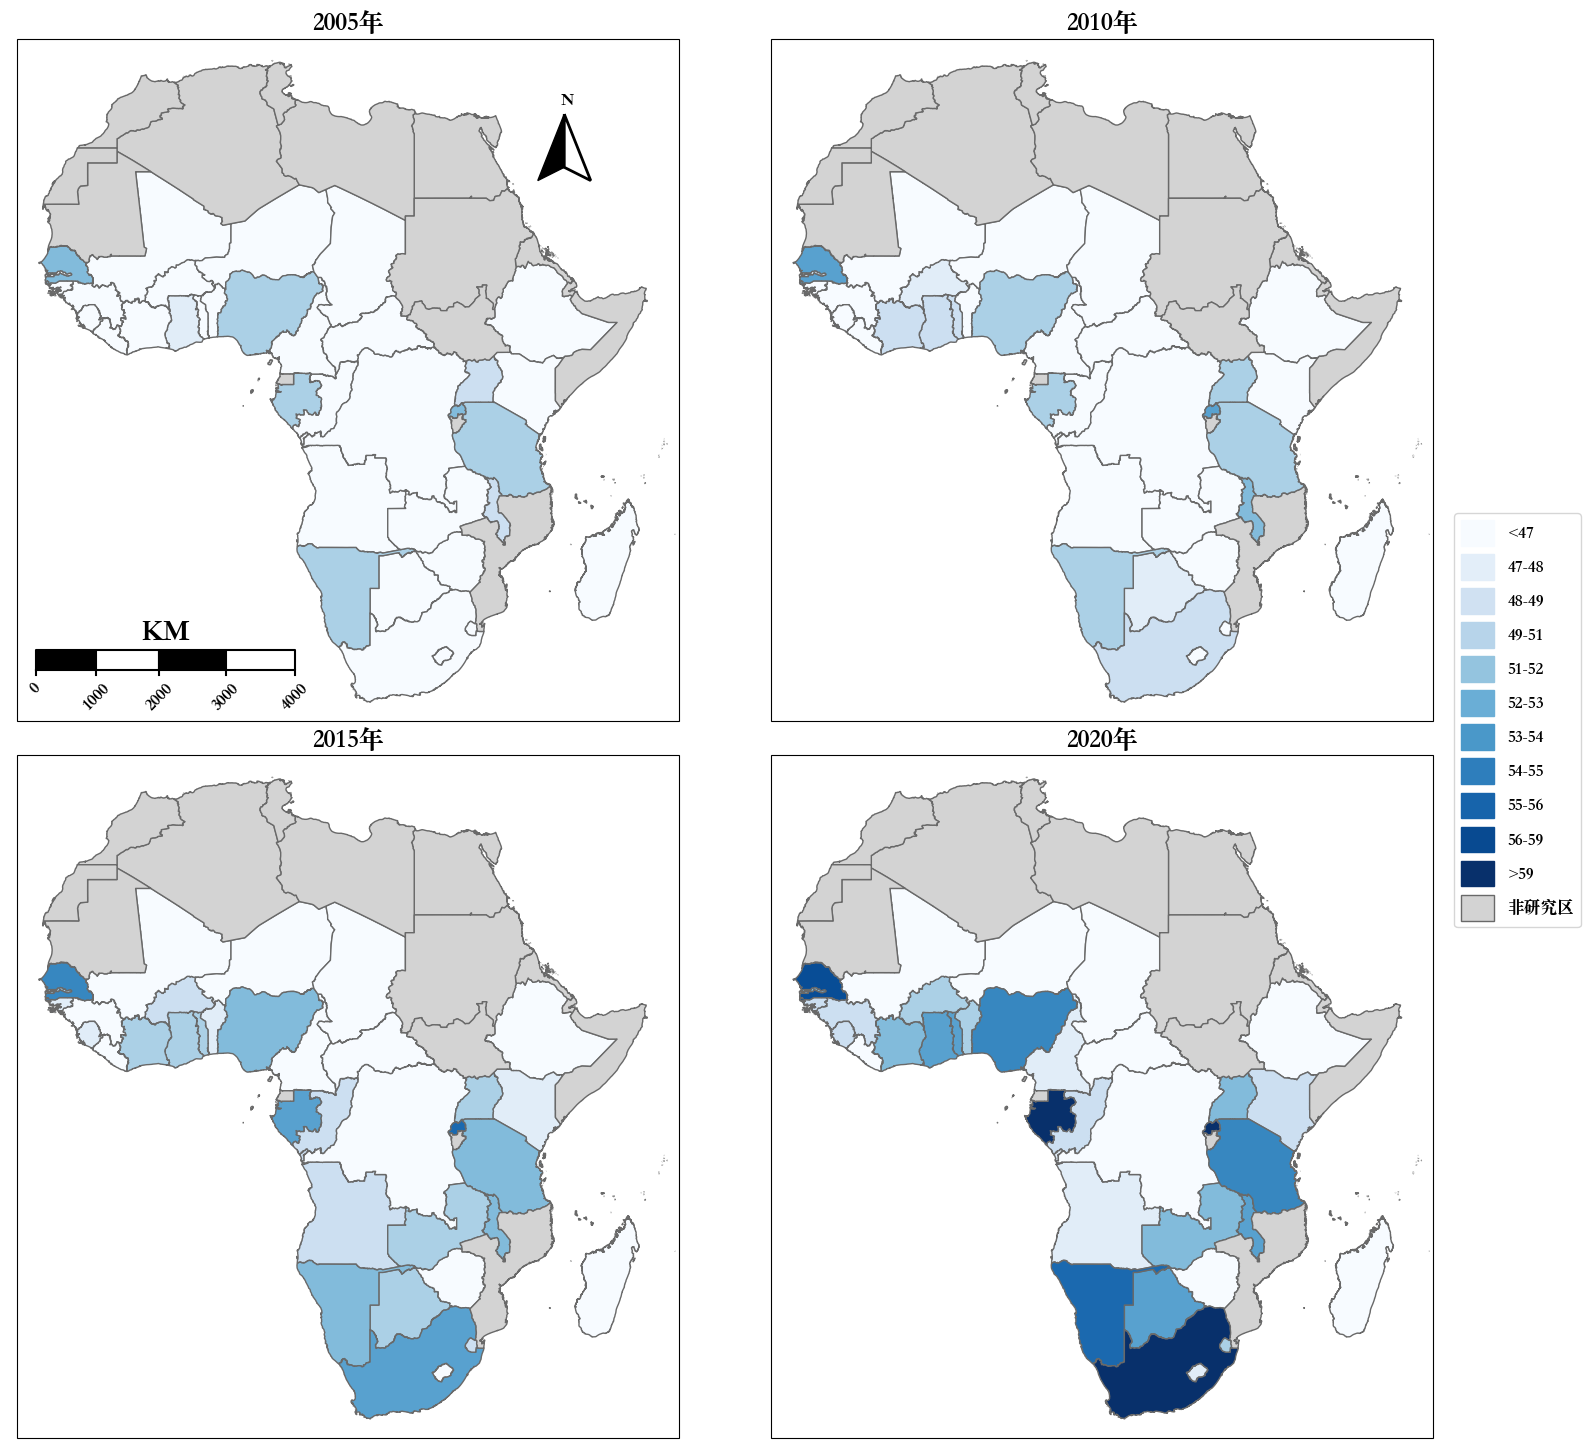

In [3]:
c = "SDI"

africa_index_map_plot(
    c,
    output_file_path=Path.home() / "OneDrive" / "PhD Dissertation" / "Pictures" / f"{c}.png",
    bins=indexes[c],
)

In [4]:
index = "SDI"
data.query("Year == 2005").sort_values(index, ascending=False).dropna(subset=[index])[["CNAME", index, "Region"]].iloc[[0, -1], :]

,CNAME,SDI,Region
544,毛里求斯,52.496704,S
640,尼日尔,37.740295,W


In [5]:
data.query("Year == 2020").sort_values(index, ascending=False).dropna(subset=[index])[["CNAME", index, "Region"]].iloc[[0, -1], :]

,CNAME,SDI,Region
639,南非,56.736623,S
863,乍得,40.150319,C


In [6]:
sdi2020 = data.query("Year == 2020")["SDI"].agg(["min", "max"])
sdi2005 = data.query("Year == 2005")["SDI"].agg(["min", "max"])
md(f"""2005-2020年间，其最高与最低的可持续发展水平最比值由2005年的{sdi2005["max"]/sdi2005["min"]:.2f}:1下降至2020年的{sdi2020["max"]/sdi2020["min"]:.2f}:1。""")

2005-2020年间，其最高与最低的可持续发展水平最比值由2005年的1.39:1下降至2020年的1.41:1。

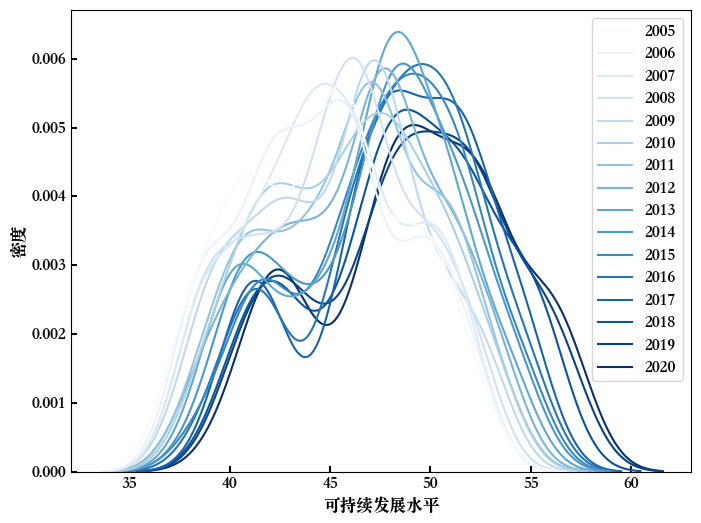

In [7]:
common_tick_params = dict(
    direction="in",
    length=4,
    width=1.5,
    colors="black",
    grid_color="black",
    grid_alpha=0.5,
)

def plot_kde(column, title, output_file_name=None):
    if output_file_name is None:
        output_file_name = f"{title}密度图"

    plt.figure(figsize=(8, 6))
    ax = sns.kdeplot(data=data, x=column, hue="Year", bw_adjust=0.7, legend=True, palette=palette)
    ax.set(xlabel=title, ylabel="密度")
    ax.legend_.set_title(None)
    plt.tick_params(left=True, bottom=True, **common_tick_params)
    plt.savefig(output / f"{output_file_name}.png", bbox_inches="tight", dpi=300)
plot_kde("SDI", "可持续发展水平", "可持续发展指数密度图")

In [8]:
region_map = {
    "W": "西非",
    "E": "东非",
    "S": "南非",
    "C": "中非",
}


def format_region_count(df):
    region_count = df.groupby("Region").count().iloc[:, 0].sort_values(ascending=False)
    result = [f"{region_map[i]}{v}个" for i, v in region_count.items()]
    if len(result) == 1:
        return f"均为{region_map[region_count.index[0]]}"
    else:
        return "，".join(result)


def join_economies(economies):
    return "、".join(economies[:-1]) + "和" + economies[-1]


sdi_growth = ((data.query("Year == 2020").set_index("Numeric")["SDI"] / data.query("Year == 2005").set_index("Numeric")["SDI"]) ** (1 / (2020 - 2005)) - 1).to_frame("SDI_Growth").sort_values("SDI_Growth", ascending=False)
sdi_growth = sdi_growth.merge(dfgeo, left_index=True, right_index=True)
sdi_growth.index = sdi_growth.index.astype("int64")
sdi_growth = sdi_growth.merge(data[["Numeric", "CNAME"]].drop_duplicates(), left_index=True, right_on="Numeric").drop(columns=["Numeric", "Fuel-exporting countries", "IMFgroup"]).set_index("CNAME").sort_values("SDI_Growth", ascending=False)
lower_middle_growth = sdi_growth.query("SDI_Growth < 0.005 and SDI_Growth >= 0")
upper_middle_growth = sdi_growth.query("SDI_Growth < 0.01 and SDI_Growth >= 0.005")

roi_num = data.query("Year == 2020").count()["SDI_Economy"]
md(f"""
###
其中，年均增速达1%以上的国家有{join_economies(sdi_growth.query("SDI_Growth >= 0.01").index)}（{format_region_count(sdi_growth.query("SDI_Growth >= 0.01"))}）；年均增速处于0.5%至1%的国家有{join_economies(upper_middle_growth.index)}（{format_region_count(upper_middle_growth)}）；年均增速低于0.5%但仍为正的国家有{lower_middle_growth.shape[0]}个（{format_region_count(lower_middle_growth)}）；有{sdi_growth.query("SDI_Growth < 0").shape[0]}个国家的年均增长率表现为负增长（{format_region_count(sdi_growth.query("SDI_Growth < 0"))}）。
""")

KeyError: "['Fuel-exporting countries'] not found in axis"

In [ ]:
sdi_growth.query("SDI_Growth < 0")

,SDI_Growth,Region
CNAME,,
肯尼亚,-0.001617,E


In [ ]:
region_map = {
    "W": "西非",
    "E": "东非",
    "S": "南非",
    "C": "中非",
}


def format_region_count(df):
    region_count = df.groupby("Region").count().iloc[:, 0].sort_values(ascending=False)
    result = [f"{region_map[i]}{v}个" for i, v in region_count.items()]
    if len(result) == 1:
        return f"均为{region_map[region_count.index[0]]}"
    else:
        return "，".join(result)


def join_economies(economies):
    return "、".join(economies[:-1]) + "和" + economies[-1]


sdi_economy_growth = ((data.query("Year == 2020").set_index("Numeric")["SDI_Economy"] / data.query("Year == 2005").set_index("Numeric")["SDI_Economy"]) ** (1 / (2020 - 2005)) - 1).to_frame("SDI_Economy_Growth").sort_values("SDI_Economy_Growth", ascending=False)
sdi_economy_growth = sdi_economy_growth.merge(dfgeo, left_index=True, right_index=True)
sdi_economy_growth.index = sdi_economy_growth.index.astype("int64")
sdi_economy_growth = sdi_economy_growth.merge(data[["Numeric", "CNAME"]].drop_duplicates(), left_index=True, right_on="Numeric").drop(columns=["Numeric", "Fuel-exporting countries", "IMFgroup"]).set_index("CNAME").sort_values("SDI_Economy_Growth", ascending=False)
lower_middle_growth = sdi_economy_growth.query("SDI_Economy_Growth < 0.005 and SDI_Economy_Growth >= 0")
upper_middle_growth = sdi_economy_growth.query("SDI_Economy_Growth < 0.01 and SDI_Economy_Growth >= 0.005")

roi_num = data.query("Year == 2020").count()["SDI_Economy"]
md(f"""
### 4.3.2 非洲可持续经济增长水平的时空演变轨迹

2005-2020年间，撒哈拉以南非洲{roi_num}个国家的可持续经济增长水平得分过半呈下降趋势，仅{sdi_economy_growth.query("SDI_Economy_Growth > 0").shape[0]}个国家呈增长趋势。其中，年均增速达1%以上的国家有{join_economies(sdi_economy_growth.query("SDI_Economy_Growth >= 0.01").index)}（{format_region_count(sdi_economy_growth.query("SDI_Economy_Growth >= 0.01"))}）；年均增速处于0.5%至1%的国家有{join_economies(upper_middle_growth.index)}（{format_region_count(upper_middle_growth)}）；年均增速低于0.5%但仍为正的国家有{lower_middle_growth.shape[0]}个（{format_region_count(lower_middle_growth)}）；有{sdi_economy_growth.query("SDI_Economy_Growth < 0").shape[0]}个国家的年均增长率表现为负增长（{format_region_count(sdi_economy_growth.query("SDI_Economy_Growth < 0"))}）。
""")


### 4.3.2 非洲可持续经济增长水平的时空演变轨迹

2005-2020年间，撒哈拉以南非洲26个国家的可持续经济增长水平得分过半呈下降趋势，仅11个国家呈增长趋势。其中，年均增速达1%以上的国家有多哥、马拉维、刚果(金)和科特迪瓦（西非2个，中非1个，南非1个）；年均增速处于0.5%至1%的国家有冈比亚和加纳（均为西非）；年均增速低于0.5%但仍为正的国家有5个（西非3个，中非1个，东非1个）；有15个国家的年均增长率表现为负增长（东非5个，南非5个，西非3个，中非2个）。


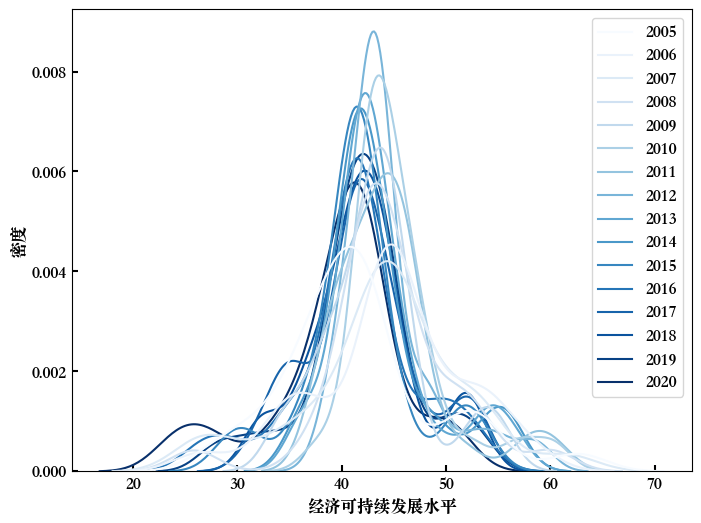

In [ ]:
plot_kde("SDI_Economy", "经济可持续发展水平", "经济增长密度图")

In [ ]:
md("图4.9为撒哈拉以南非洲在2005-2020年间可持续经济增长水平的核密度图。可以看出，核密度图的峰值呈波动上升的态势，且峰值凸显。这表明，撒哈拉以南非洲国家可持续经济增长水平整体呈螺旋上升态势，较高和较低水平国家的数量都较少，多数国家可持续经济增长水平集中在60附近。")

图4.9为撒哈拉以南非洲在2005-2020年间可持续经济增长水平的核密度图。可以看出，核密度图的峰值呈波动上升的态势，且峰值凸显。这表明，撒哈拉以南非洲国家可持续经济增长水平整体呈螺旋上升态势，较高和较低水平国家的数量都较少，多数国家可持续经济增长水平集中在60附近。

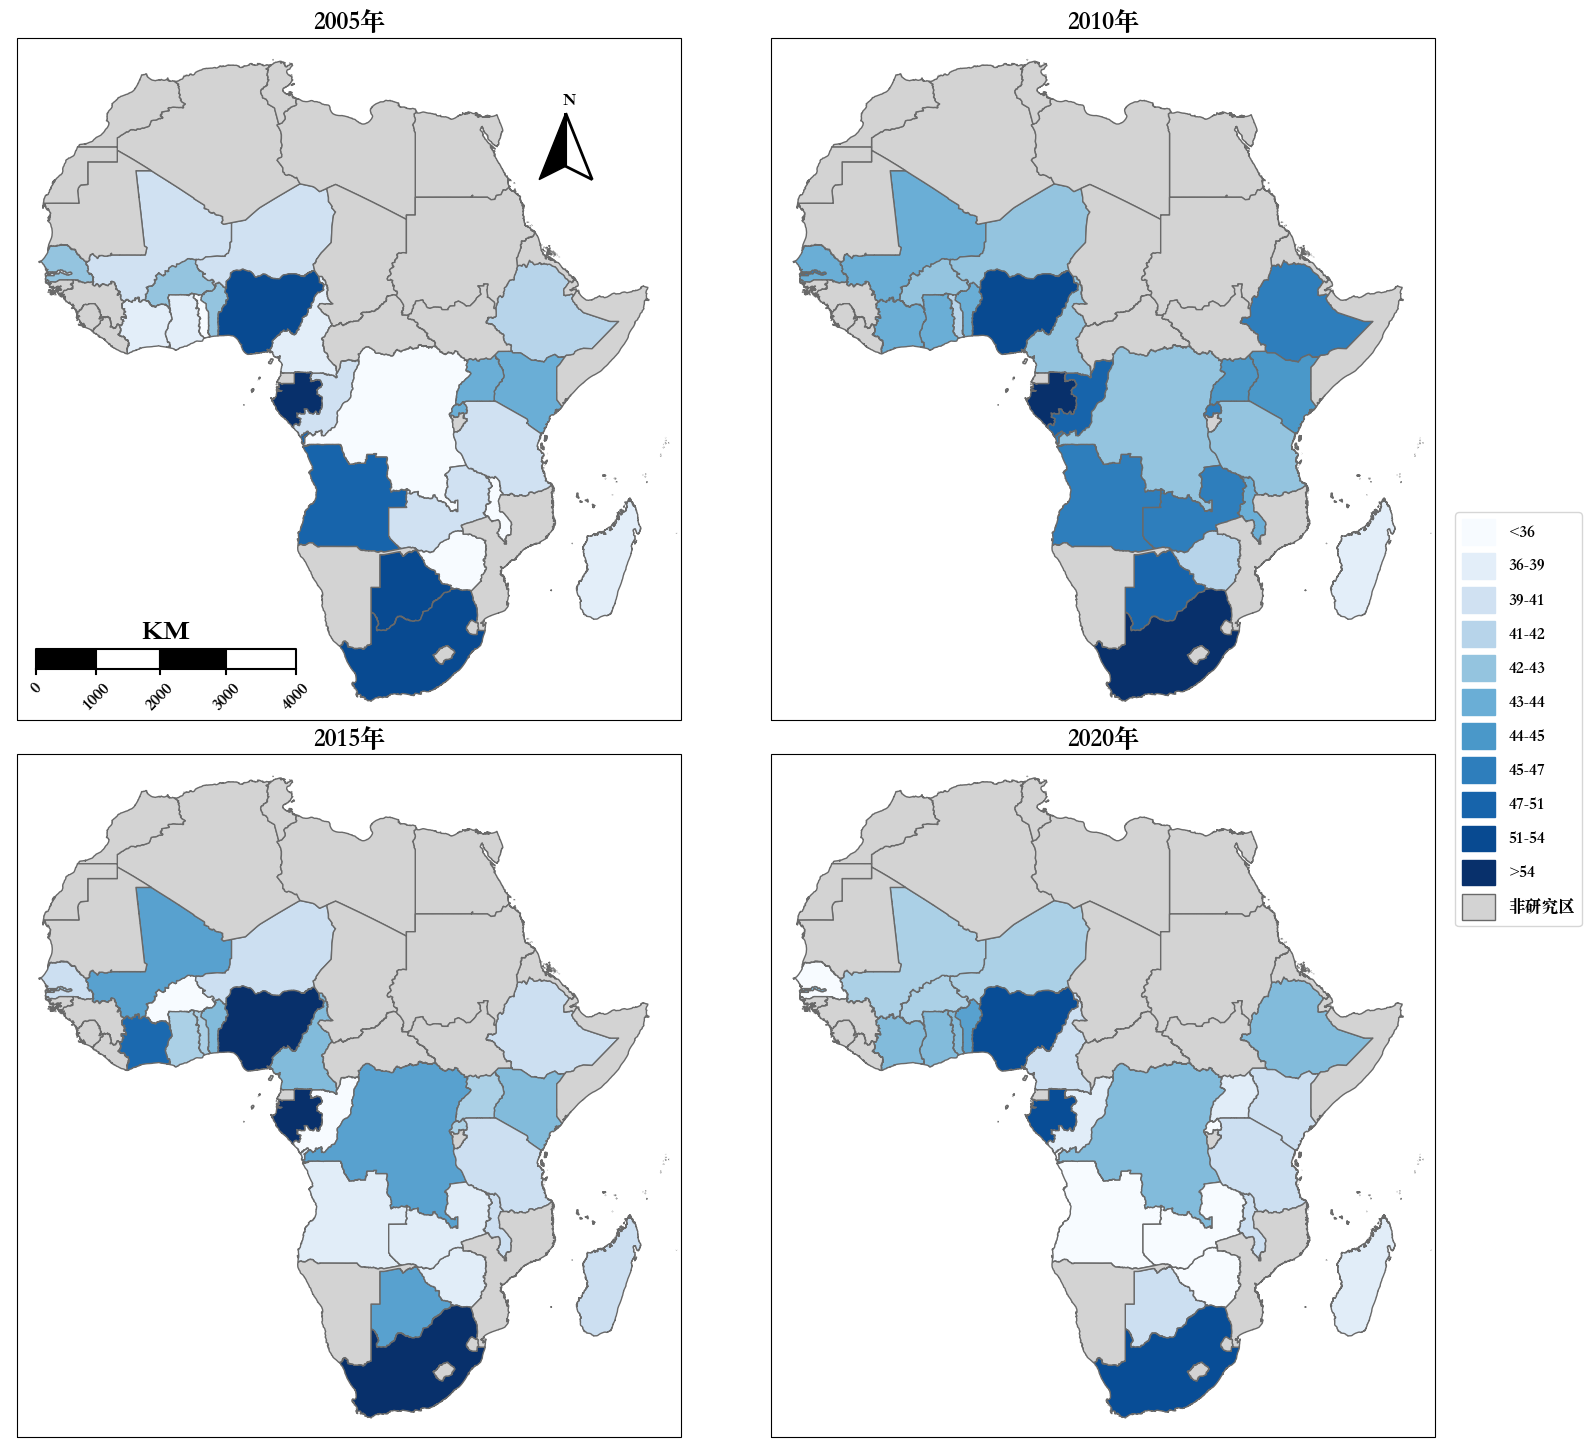

In [ ]:
c = "SDI_Economy"
africa_index_map_plot(
    c,
    output_file_path=Path.home() / "OneDrive" / "PhD Dissertation" / "Pictures" / f"{c}.png",
    bins=indexes[c],
)

In [ ]:
data[["SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]].dropna().describe()

,SDI,SDI_Economy,SDI_Society,SDI_Resource,SDI_Ecology
count,416.000000,416.000000,416.000000,416.000000,416.000000
mean,52.766681,43.057700,55.650261,47.645279,58.857193
std,3.796971,5.926456,7.801522,8.096088,8.550549
min,45.053279,23.800539,27.404479,28.048314,40.235269
25%,50.050553,40.519540,50.760543,42.344643,50.956907
50%,52.463498,42.736370,55.328663,47.021320,59.566554
75%,55.459644,45.264731,60.279349,53.171317,66.102900
max,61.323367,62.613942,80.795124,65.900867,77.997848


In [ ]:
data[["Year", "SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]].groupby("Year").mean().pct_change(15).iloc[-1]

SDI             0.083493
SDI_Economy    -0.051689
SDI_Society     0.319716
SDI_Resource    0.079139
SDI_Ecology     0.002674
Name: 2020, dtype: float64

In [ ]:
sdi_economy = data.sort_values("SDI_Economy", ascending=False).groupby("Year")["SDI_Economy"].agg(["min", "max"])
min_max_ratio = sdi_economy["max"] / sdi_economy["min"]

md(f"""图4.10揭示了撒哈拉以南非洲{roi_num}个国家可持续经济增长水平的空间分布状态。
   
2005-2020年间，撒哈拉以南{roi_num}个非洲国家之间的可持续经济增长水平存在一定的空间差异，且差异呈波动下降的态势。2005年和2020年可持续经济增长水平最高的国家均为中非的加蓬，2005年可持续经济增长水平最低的国家为西非的几内亚（比绍），2020年为西非的佛得角，差距由{min_max_ratio.loc[2005]:.2f}:1下降到{min_max_ratio.loc[2020]:.2f}:1。 

2005-2020年间，与可持续社会进步水平、可持续环境支持水平和可持续发展资源相比，非洲的可持续经济增长水平处于较低的状态，增速相对较慢，空间差距最小。
""")

图4.10揭示了撒哈拉以南非洲26个国家可持续经济增长水平的空间分布状态。
   
2005-2020年间，撒哈拉以南26个非洲国家之间的可持续经济增长水平存在一定的空间差异，且差异呈波动下降的态势。2005年和2020年可持续经济增长水平最高的国家均为中非的加蓬，2005年可持续经济增长水平最低的国家为西非的几内亚（比绍），2020年为西非的佛得角，差距由2.24:1下降到2.12:1。 

2005-2020年间，与可持续社会进步水平、可持续环境支持水平和可持续发展资源相比，非洲的可持续经济增长水平处于较低的状态，增速相对较慢，空间差距最小。


In [ ]:
sdi_society = data.set_index(["CNAME", "Year"])
growth = ((sdi_society.loc[(slice(None), 2020), "SDI_Society"].droplevel("Year")/sdi_society.loc[(slice(None), 2005), "SDI_Society"].droplevel("Year")) ** (1 / (2020 - 2005)) - 1).sort_values(ascending=False).to_frame("SDI_Society_Growth").merge(sdi_society.loc[(slice(None), 2020), "Region"].droplevel("Year").to_frame("Region"), left_index=True, right_index=True)
format_region_count(growth.query("SDI_Society_Growth >= 0.02"))
high_growth = growth.query("SDI_Society_Growth >= 0.02")
mid_growth = growth.query("SDI_Society_Growth < 0.02 and SDI_Society_Growth >= 0.01")
low_growth = growth.query("SDI_Society_Growth < 0.01")
md(f"""### 4.3.3 非洲可持续社会进步水平的时空演变轨迹
2005-2020年间，撒哈拉以南{roi_num}个非洲国家的可持续社会进步水平的得分总体呈上升趋势，且大部分国家的年均增速高于1%。其中，有{len(high_growth)}个年均增长率高于2%的国家（{format_region_count(high_growth)}）；年均增速在1%至2%区间的国家有{len(mid_growth)}个（{format_region_count(mid_growth)}）；低于1%的国家有{len(low_growth)}个（{format_region_count(low_growth)}）。


图4.11展示了非洲可持续社会进步水平在2005-2020年间的时间变化趋势。从峰值上看，随着时间的推移，{roi_num}个非洲国家的社会进步水平整体呈右移，且最高峰值整体呈上升的态势，位处左端可持续社会进步水平较低的国家数量也有了显著的下降，意味着非洲整体可持续社会进步水平有了明显提高。
""")

### 4.3.3 非洲可持续社会进步水平的时空演变轨迹
2005-2020年间，撒哈拉以南26个非洲国家的可持续社会进步水平的得分总体呈上升趋势，且大部分国家的年均增速高于1%。其中，有12个年均增长率高于2%的国家（南非6个，西非3个，东非2个，中非1个）；年均增速在1%至2%区间的国家有10个（西非6个，中非2个，东非2个）；低于1%的国家有4个（东非2个，中非1个，西非1个）。


图4.11展示了非洲可持续社会进步水平在2005-2020年间的时间变化趋势。从峰值上看，随着时间的推移，26个非洲国家的社会进步水平整体呈右移，且最高峰值整体呈上升的态势，位处左端可持续社会进步水平较低的国家数量也有了显著的下降，意味着非洲整体可持续社会进步水平有了明显提高。


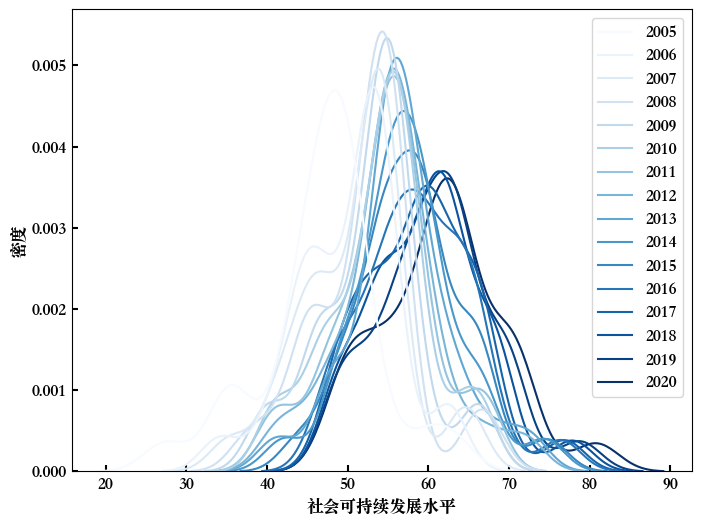

In [ ]:
plot_kde("SDI_Society", "社会可持续发展水平", "社会进步密度图")

In [ ]:
def get_minmax_ratio(index, year):
    x = data.query("Year == @year").dropna(subset=[index]).sort_values(index, ascending=False)
    max_country = x.iloc[0]
    min_country = x.iloc[-1]
    return max_country["CNAME"], min_country["CNAME"], max_country[index] / min_country[index]
get_minmax_ratio("SDI_Society", 2005)

('卢旺达', '赞比亚', 2.3021645375151456)

In [ ]:
get_minmax_ratio("SDI_Society", 2020)

('塞内加尔', '赞比亚', 1.6402670572277316)

In [ ]:
sdi_society["SDI_Society"].loc[slice(None), 2005].sort_values(ascending=False)
md("""
图4.12从空间分布上反映了撒哈拉以南非洲各国在2005-2019年间可持续社会进步水平。<del>其中，低水平国家从16个下降至0个；较低水平国家由13个下降至2个；中等水平国家由4个增长到18个；较高水平国家从0个上升到8个；高水平国家从0个增加到5个。2005年，撒哈拉以南非洲可持续社会进步水平最高的是南部和西部，而东部和中部的可持续社会进步水平多处于低水平区。</del>到2020年，可持续社会进步水平较高的区域为南部、西部和东部非洲，中部地区虽然也有所提升，但仍是可持续社会进步水平相对较低的区域。这表明，撒哈拉以南非洲可持续社会进步水平呈现中等及以上水平国家由南部向东西地区扩散，且中部非洲始终较低的空间格局。

2005-2019年间，撒哈拉以南33个非洲国家之间的可持续社会进步水平空间差异较大，但差异呈缩小的态势。2005年和2020年的可持续社会进步水平最高与最低的国家均分别是西非的佛得角和中非共和国，其水平之比为2.10:1。其可持续社会进步水平之比下降至1.66:1。

2005-2019年间，与可持续经济增长水平、可持续环境支持水平和可持续发展能力相比，非洲的可持续社会进步水平处于较高的状态，且增速最快，空间差异较小。
""")


图4.12从空间分布上反映了撒哈拉以南非洲各国在2005-2019年间可持续社会进步水平。<del>其中，低水平国家从16个下降至0个；较低水平国家由13个下降至2个；中等水平国家由4个增长到18个；较高水平国家从0个上升到8个；高水平国家从0个增加到5个。2005年，撒哈拉以南非洲可持续社会进步水平最高的是南部和西部，而东部和中部的可持续社会进步水平多处于低水平区。</del>到2020年，可持续社会进步水平较高的区域为南部、西部和东部非洲，中部地区虽然也有所提升，但仍是可持续社会进步水平相对较低的区域。这表明，撒哈拉以南非洲可持续社会进步水平呈现中等及以上水平国家由南部向东西地区扩散，且中部非洲始终较低的空间格局。

2005-2019年间，撒哈拉以南33个非洲国家之间的可持续社会进步水平空间差异较大，但差异呈缩小的态势。2005年和2020年的可持续社会进步水平最高与最低的国家均分别是西非的佛得角和中非共和国，其水平之比为2.10:1。其可持续社会进步水平之比下降至1.66:1。

2005-2019年间，与可持续经济增长水平、可持续环境支持水平和可持续发展能力相比，非洲的可持续社会进步水平处于较高的状态，且增速最快，空间差异较小。


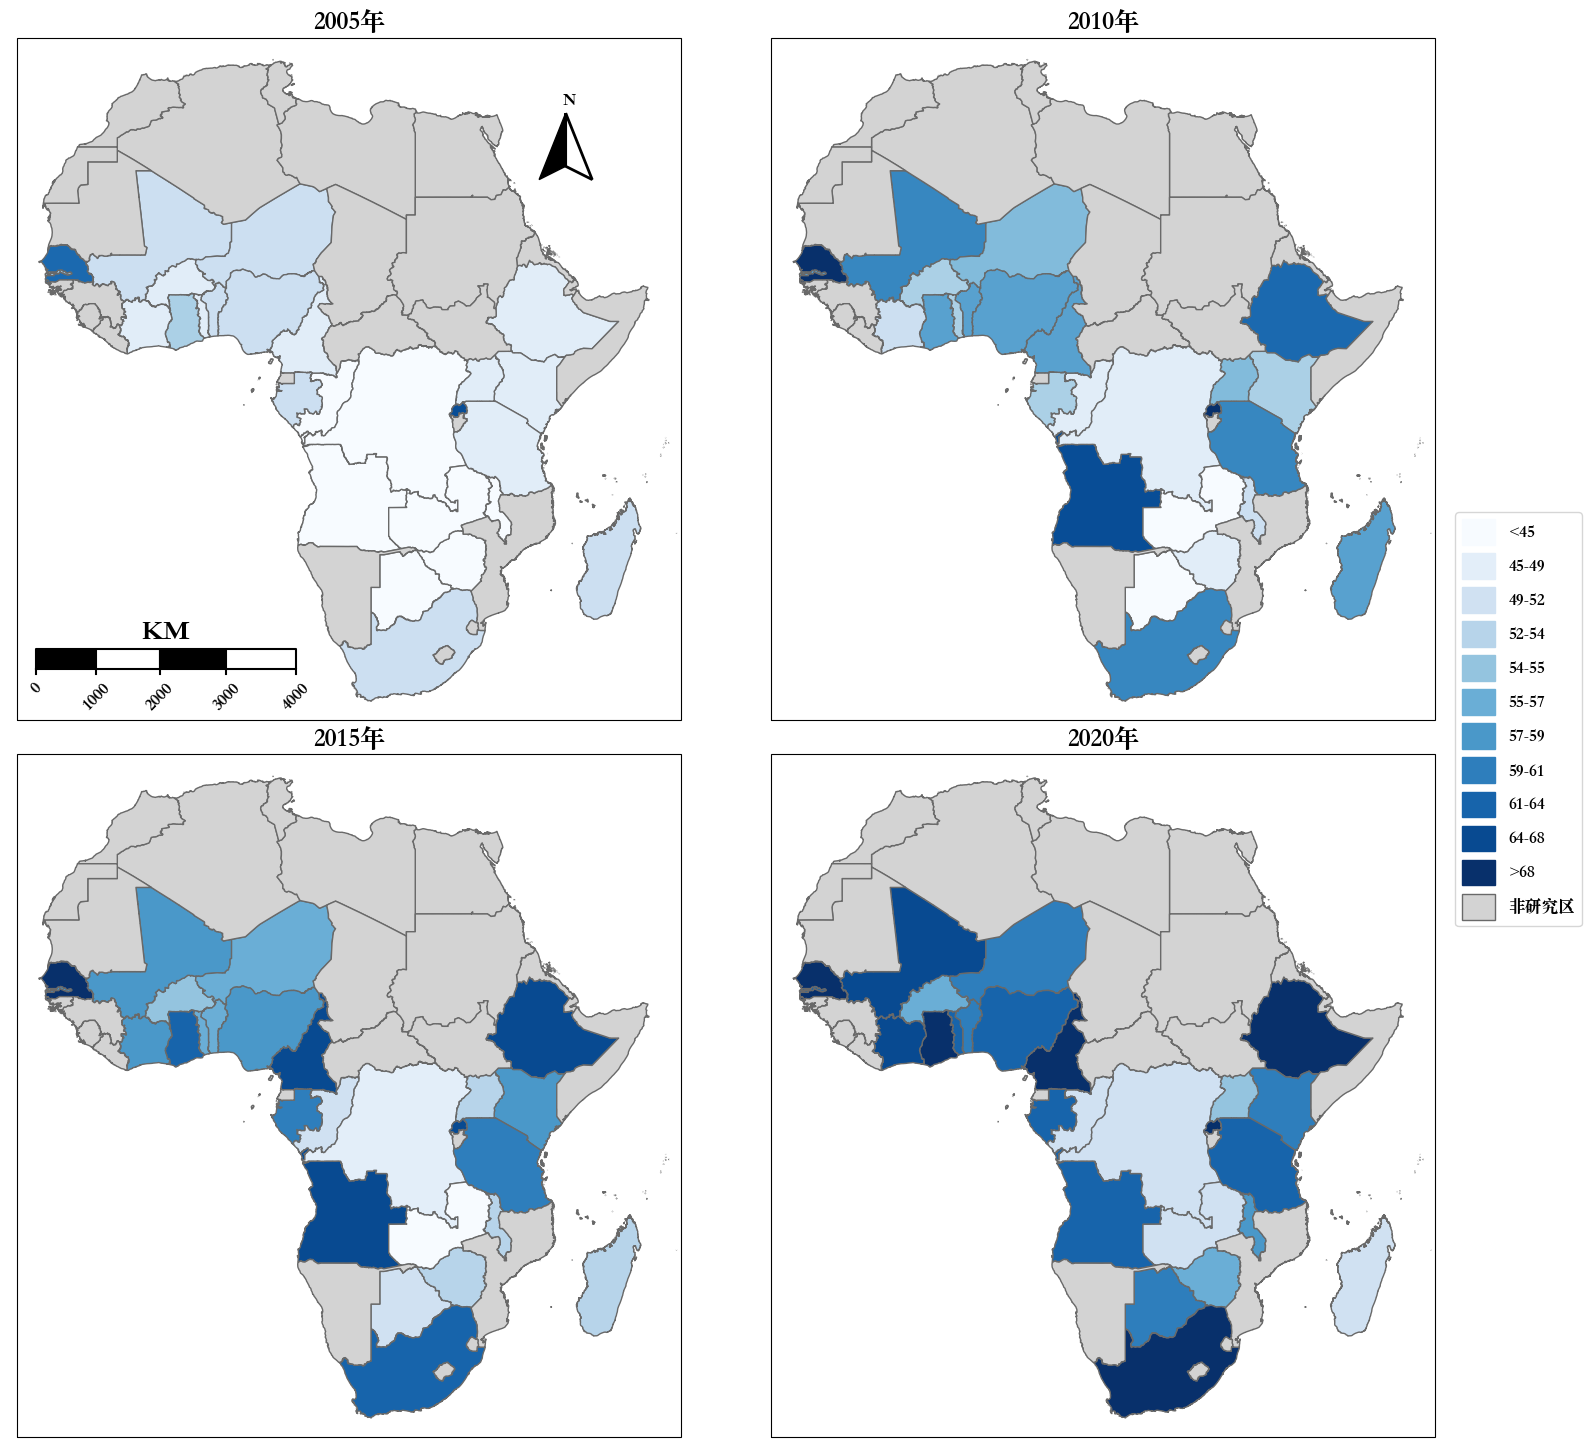

In [ ]:
africa_index_map_plot(
    "SDI_Society",
    output_file_path=output / "SDI_Society.png",
    bins=indexes["SDI_Society"],
)

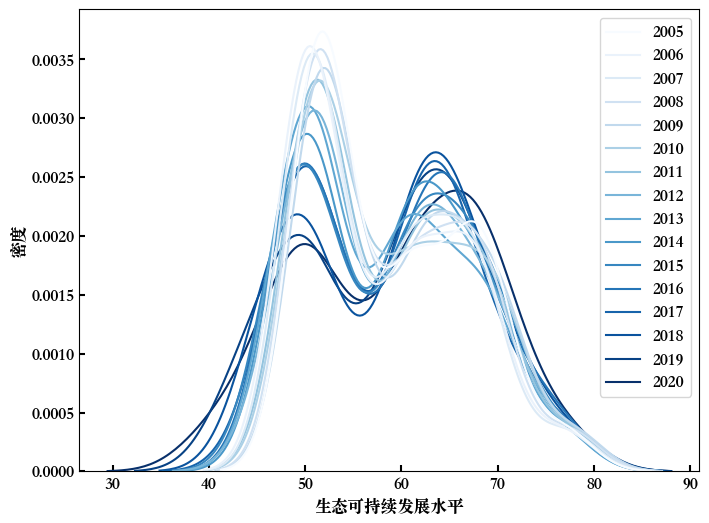

In [ ]:
plot_kde("SDI_Ecology", "生态可持续发展水平")

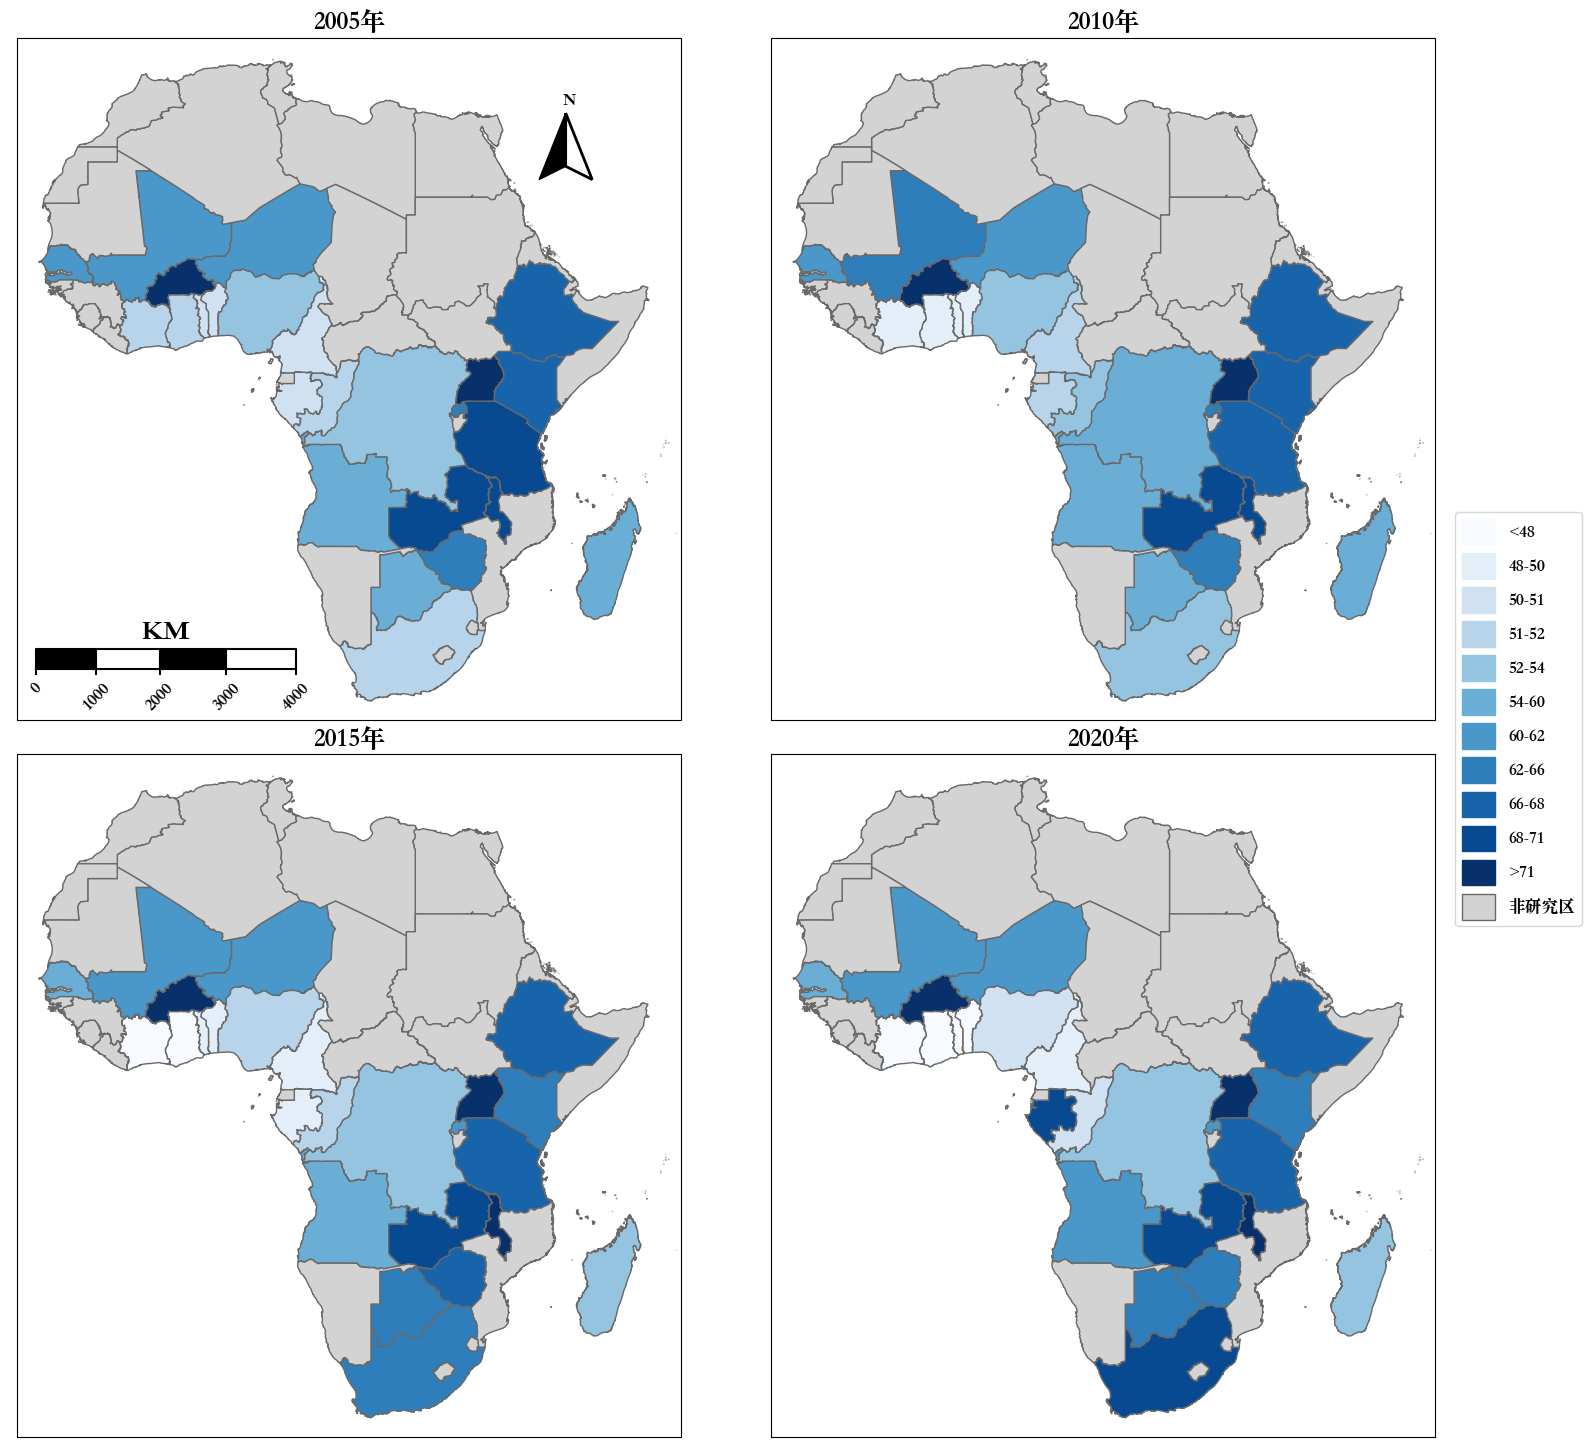

In [ ]:
africa_index_map_plot(
    "SDI_Ecology",
    output_file_path=output / "SDI_Ecology.png",
    bins=indexes["SDI_Ecology"],
)

In [ ]:
data.dropna(subset=["SDI"])[["Year", "SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]].groupby("Year").mean().pct_change(15).iloc[-1]

SDI             0.083493
SDI_Economy    -0.051689
SDI_Society     0.319716
SDI_Resource    0.079139
SDI_Ecology     0.002674
Name: 2020, dtype: float64

In [ ]:
data.dropna(subset=["SDI"])[["SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]].describe()

,SDI,SDI_Economy,SDI_Society,SDI_Resource,SDI_Ecology
count,416.000000,416.000000,416.000000,416.000000,416.000000
mean,52.766681,43.057700,55.650261,47.645279,58.857193
std,3.796971,5.926456,7.801522,8.096088,8.550549
min,45.053279,23.800539,27.404479,28.048314,40.235269
25%,50.050553,40.519540,50.760543,42.344643,50.956907
50%,52.463498,42.736370,55.328663,47.021320,59.566554
75%,55.459644,45.264731,60.279349,53.171317,66.102900
max,61.323367,62.613942,80.795124,65.900867,77.997848


In [ ]:
get_minmax_ratio("SDI_Ecology", 2005)

('布基纳法索', '加蓬', 1.5375970673070827)

In [ ]:
get_minmax_ratio("SDI_Ecology", 2020)

('布基纳法索', '加纳', 1.9209283110453574)

In [ ]:
SDI_Ecology_pct_change = ((data.query("Year == 2005 or Year == 2020").sort_values(["Year", "Numeric"]).dropna(subset=["SDI_Ecology"])[["SDI_Ecology"]].pct_change(26).iloc[26:] + 1) ** (1/16) - 1) * 100
SDI_Ecology_pct_change.index = data.dropna(subset=["SDI_Ecology"]).sort_values("Numeric")["CNAME"].unique()
SDI_Ecology_pct_change = SDI_Ecology_pct_change.sort_values("SDI_Ecology", ascending=False).merge(data[["CNAME", "Region"]].drop_duplicates(), left_index=True, right_on="CNAME")
SDI_Ecology_pct_change.query("SDI_Ecology < 0 and SDI_Ecology > -1")["Region"].value_counts()

Region
W    8
E    6
C    3
Name: count, dtype: int64

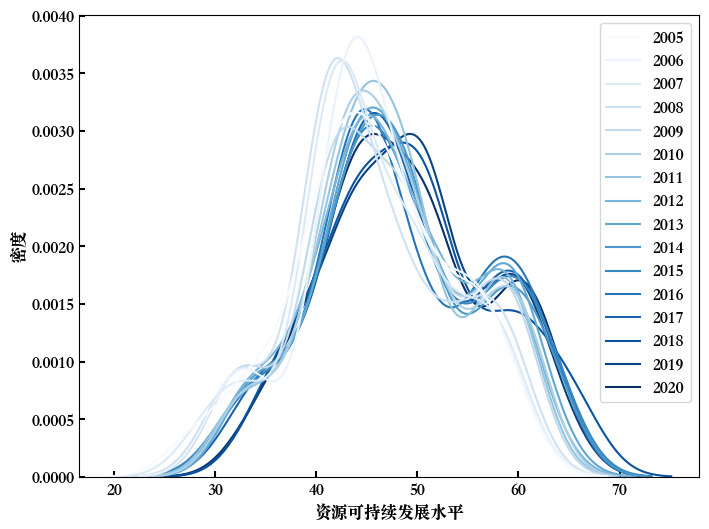

In [ ]:
plot_kde("SDI_Resource", "资源可持续发展水平")

In [ ]:
SDI_Resource_pct_change = ((data.query("Year == 2005 or Year == 2020").sort_values(["Year", "Numeric"]).dropna(subset=["SDI_Resource"])[["SDI_Resource"]].pct_change(26).iloc[26:] + 1) ** (1/16) - 1) * 100
SDI_Resource_pct_change.index = data.dropna(subset=["SDI_Resource"]).sort_values("Numeric")["CNAME"].unique()
SDI_Resource_pct_change = SDI_Resource_pct_change.sort_values("SDI_Resource", ascending=False).merge(data[["CNAME", "Region"]].drop_duplicates(), left_index=True, right_on="CNAME")
SDI_Resource_pct_change.query("SDI_Resource < 1 and SDI_Resource > 0")["Region"].value_counts()

Region
W    9
E    4
S    4
C    3
Name: count, dtype: int64

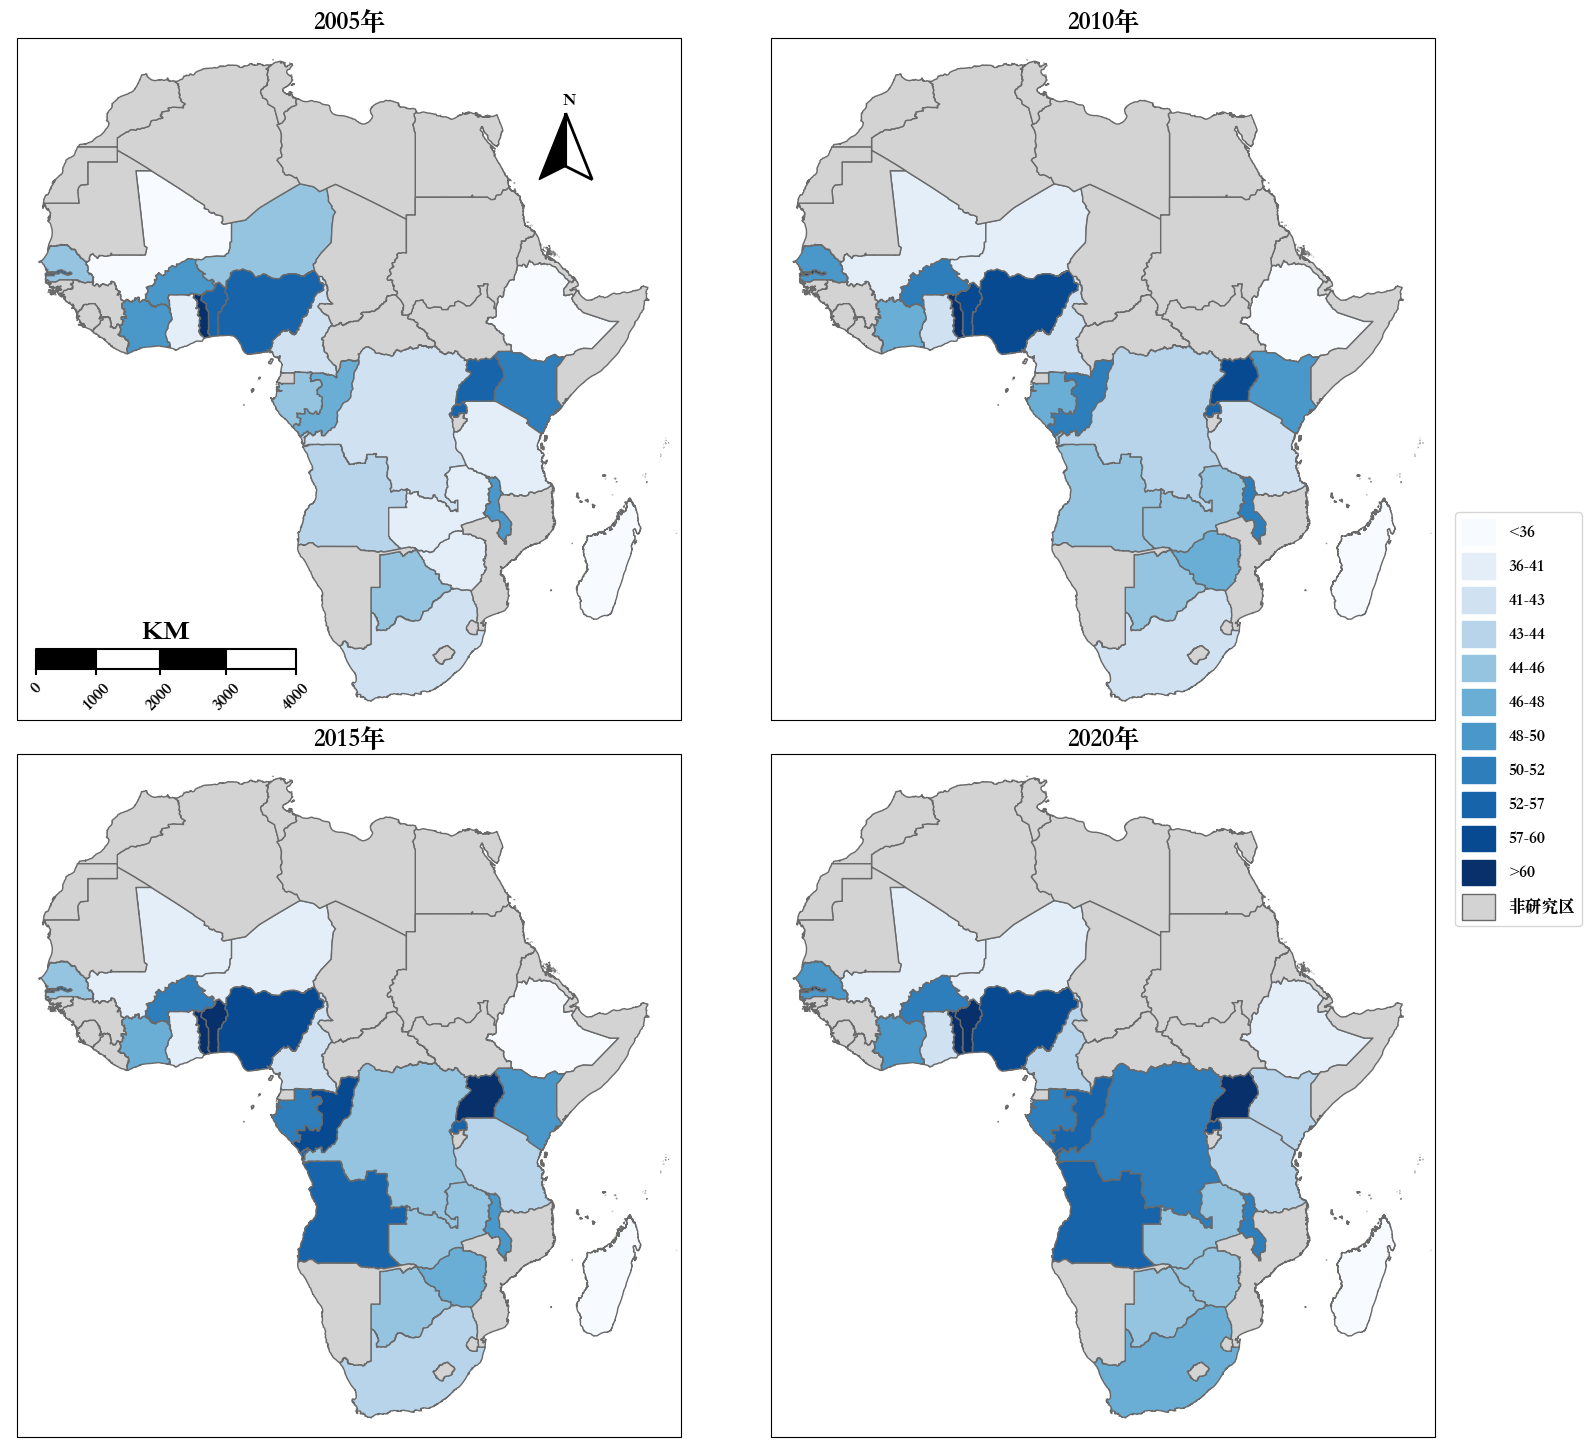

In [ ]:
africa_index_map_plot(
    "SDI_Resource",
    output_file_path=output / "SDI_Resource.png",
    bins=indexes["SDI_Resource"],
)

In [ ]:
get_minmax_ratio("SDI_Resource", 2005), get_minmax_ratio("SDI_Resource", 2020)

(('多哥', '埃塞俄比亚', 2.1409314735194487), ('多哥', '马达加斯加', 1.8971735895084094))

In [ ]:
data.dropna(subset=["SDI"])[["SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]].describe()

,SDI,SDI_Economy,SDI_Society,SDI_Resource,SDI_Ecology
count,416.000000,416.000000,416.000000,416.000000,416.000000
mean,52.766681,43.057700,55.650261,47.645279,58.857193
std,3.796971,5.926456,7.801522,8.096088,8.550549
min,45.053279,23.800539,27.404479,28.048314,40.235269
25%,50.050553,40.519540,50.760543,42.344643,50.956907
50%,52.463498,42.736370,55.328663,47.021320,59.566554
75%,55.459644,45.264731,60.279349,53.171317,66.102900
max,61.323367,62.613942,80.795124,65.900867,77.997848


In [ ]:
data.dropna(subset=["SDI"])[["CNAME", "Year", "Region", "SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]].set_index(["CNAME", "Year"]).groupby("Region").mean()

,SDI,SDI_Economy,SDI_Society,SDI_Resource,SDI_Ecology
Region,,,,,
C,49.738044,44.497452,53.099467,46.898819,51.886537
E,54.476813,42.226358,57.906108,45.226640,64.417114
S,53.030942,42.930997,51.298598,46.343102,63.534495
W,52.793502,43.056625,57.928069,50.176353,55.503122


In [ ]:
x = data.dropna(subset=["SDI"])[["CNAME", "Year", "Region", "SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]].set_index(["CNAME", "Year", "Region"]).groupby(["Year"]).mean()
x.loc[2020] - x.loc[2005]

SDI              4.174985
SDI_Economy     -2.159039
SDI_Society     14.946002
SDI_Resource     3.600779
SDI_Ecology      0.157927
dtype: float64

In [ ]:
x = data.dropna(subset=["SDI"])[["CNAME", "Year", "Region", "SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]].set_index(["CNAME", "Year"]).groupby(["Year", "Region"]).mean()
x.loc[2020] - x.loc[2005]

,SDI,SDI_Economy,SDI_Society,SDI_Resource,SDI_Ecology
Region,,,,,
C,5.291425,-2.698244,13.296538,4.901835,3.667905
E,2.383485,-3.264367,11.116420,3.366757,-1.756507
S,7.229286,-7.705520,21.534659,5.412772,5.456920
W,2.970727,2.047728,13.950344,2.133575,-3.276800


In [ ]:
x = data[["CNAME", "Year", "Region", "SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology"]].set_index(["CNAME", "Region", "Year"]).dropna()
((x.loc[(slice(None), slice(None), 2020), ].droplevel(2) / x.loc[(slice(None), slice(None), 2005), ].droplevel(2)) ** (1/16) - 1).sort_values("SDI", ascending=False)

,,SDI,SDI_Economy,SDI_Society,SDI_Resource,SDI_Ecology
CNAME,Region,,,,,
南非,S,0.013696,-0.003697,0.022343,0.007919,0.017813
加蓬,C,0.009549,-0.017447,0.014637,0.006233,0.019269
马拉维,S,0.009441,0.013495,0.029784,0.003085,0.003360
津巴布韦,S,0.008914,-0.005056,0.029996,0.012056,0.000633
埃塞俄比亚,E,0.008718,0.000787,0.023106,0.019224,-0.001033
安哥拉,S,0.007489,-0.034578,0.023579,0.013859,0.005826
博茨瓦纳,S,0.007479,-0.015413,0.032840,0.001370,0.005736
喀麦隆,C,0.007301,0.001529,0.027195,0.001651,-0.002147
刚果(金),C,0.006890,0.011029,0.011491,0.012190,-0.000533


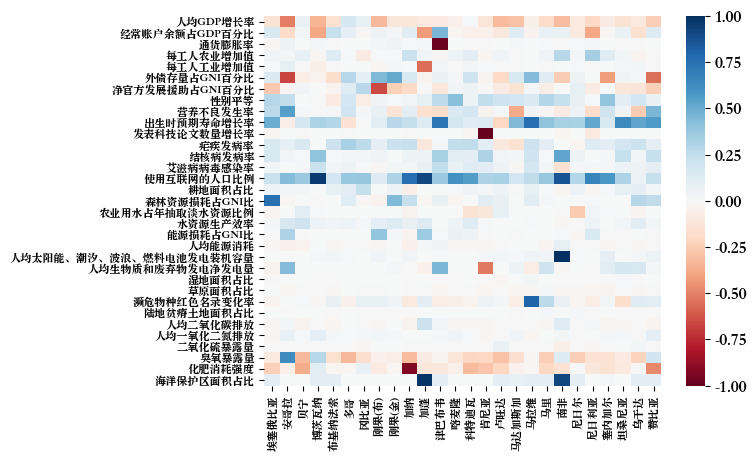

In [ ]:
from sklearn.preprocessing import minmax_scale

d = data.dropna(subset="Numeric").set_index(["CNAME", "Year"]).drop(columns=["Numeric", "ENAME", "ABENAME", "GB", "SOC", "geometry", "Alpha-3 code", "SDI", "SDI_Economy", "SDI_Society", "SDI_Resource", "SDI_Ecology", "CountryName_CN", "Region", "Fuel-exporting countries", "IMFgroup"])
pos_neg_map = variables_chosen.query("变量类型 == '指标体系'").set_index("Variables").apply(lambda row: 1 if row["类型"] == "正向" else -1, axis=1).to_dict()
rename_map = variables_chosen.query("变量类型 == '指标体系'").set_index("Variables").apply(lambda row: row["三级指标"], axis=1).to_dict()
for col in d:
    d[col] *= pos_neg_map[col]
    d[col] = minmax_scale(d[col])
d = d.rename(columns=rename_map).diff(15).loc[(slice(None), 2020), :].droplevel("Year").T
d = d.rename(columns={"几内亚（比绍）": "几内亚(比绍)"})
ax = sns.heatmap(d, xticklabels=True, yticklabels=True, cmap="RdBu", vmax=1, vmin=-1)
ax.set(xlabel="", ylabel="")
plt.tick_params(labelsize=8)